Image classifier for team ornithomimus.
---
Here's the basics of this model: 

The purpose of this classifier is to predict if a user will like or dislike a specific image. To do this, we build up a dataset of images that the user has marked as liked or disliked while swiping on the app. Any image that the user has seen is used in the training dataset, and we will send images the user has not seen to the model when making predictions.

The dataset starts with all images unrated. When a user likes or dislikes a hike, the hike name and user rating is sent from the app to this image classifier. The matching photo is then moved from the unrated folder to either the like or dislike folder. After a number of images are in the two rated folders, the training dataset can be recompiled and used to train the model.

In order to select which photos to send back to the user, we can give a photo name to the model from a list of possible hikes. The model will then predict if the hike will be liked or disliked; photos that the model predicts will be disliked are discarded, and the rest can be sent to the user.

In [ ]:
# Imports
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import pdb
from PIL import Image
import shutil

Image Classifier Steps:
---
1. Recieve ratings from user, parse information
2. Based on ratings, move photos from unrated folder into like/dislike folder in rated dataset, labelled with rating
3. Train model using updated dataset
4. Give model new, unrated photos to get recommended photos, save the output for sending to application


Image Classifier Summary
---
When using the image classifier, the following defined inputs and outputs should be used as the primary interface.

**Module input:**
- `update_and_train_model (hikes)`
    - Given a list of pairs `(String hikeName, String rating)`, updates the classifier dataset and trains the model.

**Module output:**
- `rate_hikes (hikes)`
    - Given a list of unrated hike names, rates each hike using the model. Returns a list of hike names, including only hikes from the input list which were rated positively by the model.

Function Summary
---
Model Functions:
- `label_image (img_name, label)`
    - Given an image and a label, moves the image to the correct rated folder and updates the dataset.
- `label_hike (hike_name, label)`
    - Given a hike and a label, moves the corresponding images to the correct rated folder and updates the dataset.
- `run_train (model, opt, sched)`
    - Trains the model using the optimizer and scheduler provided for a single epoch.
- `run_test (model)`
    - Tests the model.
- `run_all (model, optimizer, scheduler, n_epochs)`
    - Trains the model for n epochs, testing after each epoch.
- `predict_image_score (model, img_name)`
    - Given an image, produces a score for whether the image will be liked or disliked.
- `classify_image (model, img_name)`
    - Given an image, predicts if the image will be liked or disliked by the user.
- `classify_hike (model, hike_name)`
    - Given a hike, predicts if the hike will be liked or disliked by the user based on the mean rating of its images.

Quality of Life Functions:
- `print_dataset_samples (num_samples, dataset)`
    - Prints the first `num_samples` images from the specified dataset.
- `print_unrated_image (img_name)`
    - Given an image name, predicts whether the image will be liked or disliked and prints the image with its predicted rating.

___
Here's the plan:

We will use a dataset in 2 main folders. The first folder contains the rated data, and has two subfolders: likes and dislikes. The third folder will contain images that have not been rated yet, and can be moved to the rated folders when reviews are received.

When the user rates a hike, the 3 corresponding photos will be moved from the unrated folder to the appropriate rated folder. At this time, the dataset will be recompiled using the new photos. Since the number of rated photos is relatively small compared to the number of unrated photos, rebuilding the dataset does not take much time.

In [ ]:
# For testing, upload 291_test_dataset.zip to your notebook and unzip it
# The test dataset can be found in reports/M2/image-classifier
!unzip 291_test_dataset.zip

In [ ]:
# Reset all images

dirs = ["291_test_dataset/full_dataset/likes", "291_test_dataset/full_dataset/dislikes"]
target_dir = "291_test_dataset/unrated"

for source_dir in dirs:
    for my_file in os.listdir(source_dir):
        shutil.move(f"{source_dir}/{my_file}", target_dir)


The following functions are used to move photos around in the datasets. The first function takes the name of an image and its labelled rating as input, and moves it to the appropriate folder for the training dataset.

In [ ]:
# Takes the name of an image as a string, moves the image to the appropriate folder

def label_image(img_name,label):
    source_dir = "291_test_dataset/unrated"
    if not(os.path.isfile(f"{source_dir}/{img_name}.jpg")):
        # If an image is missing from a hike, ignore it
        return
    
    if label == 1: # Image is liked
        target_dir = "291_test_dataset/full_dataset/likes"
    else: # Image is disliked
        target_dir = "291_test_dataset/full_dataset/dislikes"
    
    shutil.move(f"{source_dir}/{img_name}.jpg", target_dir)

This updated function labels all images related to a single hike at once. If a hike has fewer than 3 images, the missing images are ignored.

In [ ]:
# Takes the name of a hike as a string, updates the datasets as appropriate

def label_hike(hike_name, label):
    for i in range(3):
        image_name = hike_name + '-' + str(i)
        label_image(image_name, label)

This is the primary input function for the image classifier. Calling this function with a list of hikes will update the dataset and train the model.

In [ ]:
def update_and_train_model(hikes):
    # Label each hike in the given list
    for (hike_name, label) in hikes:
        label_hike(hike_name, label)
    # Update the dataset for training only
    dataset_train = datasets.ImageFolder('291_test_dataset/full_dataset', transform=xform)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)

    # Train the classifier for one epoch
    run_train(model, optimizer, scheduler)


To increase the effective size of our dataset, we are using as much data augmentation as practical. Since our images are generally of landscapes, transforms such as rotation, vertical flips, and large crops are unrealistic. Instead, we are using horizontal flips, random gaussian blur, and random color manipulation. All of the augmentations are subtle, and could be interpreted as filters used by people posting images on social media.

In [ ]:
xform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ColorJitter(brightness=0.1,contrast=0.3,saturation=0.2),
                            transforms.GaussianBlur(kernel_size=5),
                            transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('291_test_dataset/full_dataset', transform=xform)

In [ ]:
# Simple convenience function for printing a number of samples from each dataset
def print_dataset_samples(num_samples=10, dataset="train"):
    for i in range(num_samples):
        if dataset == "train":
            img = dataset_train[i]
        elif dataset == "test":
            img = dataset_test[i]
        else:
            img = dataset_full[i]
        plt.imshow(img[0].permute(1,2,0))
        print(dataset_full.classes[img[1]])
        plt.show()

dislikes


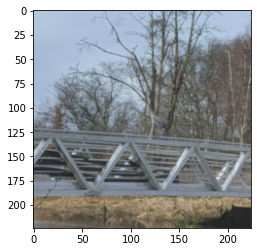

dislikes


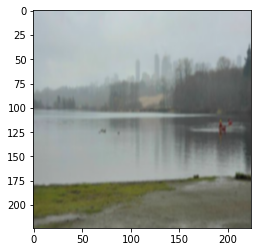

In [ ]:
print_dataset_samples(2, "full")

Outside of testing, we want to use all of the available images for training. While testing, however, it is useful to have some photos available to verify that the model is making reasonable predictions. While testing, split the dataset into training and testing datasets.

In [ ]:
n_all = len(dataset_full)
n_train = int(0.6 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(3621)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
print(len(dataset_test), len(dataset_train))

20 28


In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

Making the model
---
Since our dataset is so small, there is little point in having a complex model. So, our goal is to have a model that is "good enough" while being as fast as possible. We tested a few candidates for use as a pretrained model, and found that of DenseNet, ResNet, MobileNet, and VGG-16, ResNet-18 seems to be the best candidate. Running on a cpu, ResNet was about 5 times faster than the other 4 options, while providing comparable accuracy.

The main challenge now is to figure out how to reduce overfitting. Since the dataset size is determined by the number of swipes the user has done, it starts at 0 images and grows linearly. As such, it is very easy for the model to overtrain and memorize the few dozen photos it has. To reduce the chance of overfitting, we will use plenty of data augmentation, as well as dropout.

In [ ]:
# Create a model using ResNet
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(p=0.2),
                         nn.Linear(model.fc.in_features, 2))
torch.nn.init.xavier_uniform_(model.fc[1].weight)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Parameter containing:
tensor([[-0.0281,  0.0163, -0.0154,  ..., -0.0065, -0.0929, -0.0237],
        [-0.0275, -0.0778,  0.0346,  ...,  0.0261, -0.1038, -0.0211]],
       requires_grad=True)

In [ ]:
device = torch.device('cpu')
model = model.to(device)

Our model is currently set up as a simple binary classifier with standard parameters. More testing could be done to find the optimal parameters, but again, the model simply needs to be good enough without being too slow. 

One notable point: We have momentum set to 0, since the dataset is constantly updating. It makes no sense for older photos to have a greater impact than new ones, so this parameter reflects this.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

These definitions have been taken directly from my (Andrew's) assignment 2. 

In [ ]:
def run_train(model, opt, sched):
  nsamples_train = len(dataset_train)
  loss_sofar, correct_sofar = 0, 0
  model.train()
  with torch.enable_grad():
    for samples, labels in loader_train:
      samples = samples.to(device)
      labels = labels.to(device)
      opt.zero_grad()
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      loss = criterion(outs, labels)
      loss.backward()
      opt.step()
      loss_sofar += loss.item() * samples.size(0)
      correct_sofar += torch.sum(preds == labels.detach())
  sched.step()
  return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_test(model):
  n_test = len(dataset_test)
  loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for samples, labels in loader_test:
      samples = samples.to(device)
      labels = labels.to(device)
      outs = model(samples)
      loss += criterion(outs, labels)
      _, preds = torch.max(outs.detach(), 1)
      correct_mask = preds == labels
      correct += correct_mask.sum(0).item()
  return loss / n_test, correct / n_test

def run_all(model, optimizer, scheduler, n_epochs):
  for epoch in range(n_epochs):
    loss_train, acc_train = run_train(model, optimizer, scheduler)
    loss_test, acc_test = run_test(model)
    print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.2297 acc 0.4286, test loss 0.1992 acc 0.5500
epoch 1: train loss 0.6920 acc 0.6429, test loss 0.2203 acc 0.4000
epoch 2: train loss 0.7064 acc 0.6786, test loss 0.1674 acc 0.6000
epoch 3: train loss 0.3656 acc 0.8929, test loss 0.1656 acc 0.7000
epoch 4: train loss 0.5384 acc 0.7143, test loss 0.1791 acc 0.5500
epoch 5: train loss 0.4658 acc 0.8214, test loss 0.2291 acc 0.5500
epoch 6: train loss 0.4087 acc 0.8214, test loss 0.2098 acc 0.4000
epoch 7: train loss 0.5932 acc 0.7500, test loss 0.1946 acc 0.6000
epoch 8: train loss 0.3479 acc 0.8571, test loss 0.2349 acc 0.5500
epoch 9: train loss 0.2686 acc 0.9286, test loss 0.2535 acc 0.4500


Up next are functions for working with single, unrated images. First, `classify_images` takes the name of an image in the unrated folder and predicts if it is a like or a dislike. This will be used to make predictions on which items to recommend to the user.

`print_unrated_image` is a convenience function for displaying an unrated image alongside its predicted rating.

In [ ]:
# Given a single image in the unraetd folder, predict a score for each class
def predict_image_score(model, img_name):
    # Find the image in the folder and prepare it for the model
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return torch.tensor([[1.,-1.]])

    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image

    model.eval()
    with torch.no_grad():
        img = img.to(device).unsqueeze(0) # Add a dimension so the model can use it
        out = model(img)
    return out.detach()

# Given a single image in the unrated folder, predict how the user will rate it
def classify_image(model, img_name):
    score = predict_image_score(model, img_name)
    _, pred = torch.max(score, 1)
    return pred.item()


# Convenience function for displaying an unrated image with its predicted rating
def print_unrated_image(img_name):
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return 0
    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image
    plt.imshow(img.permute(1,2,0))
    print("Predicted class:", dataset_full.classes[classify_image(model, img_name)])

Predicted class: dislikes


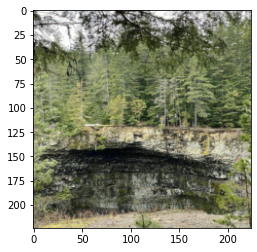

In [ ]:
print_unrated_image("brandywine-trail-1")

For our full implementation, we will be working with entire hikes instead of single images. For this, we need to be able to process up to 3 images to rate a hike. The following function takes a hike name as input, finds all related images, and predicts if the hike will be liked by looking at the mean score for all of its images.

In [ ]:
def classify_hike(model, hike_name):
    source_dir = "291_test_dataset/unrated"
    image_scores = []
    for i in range(3):
        image_name = hike_name + '-' + str(i)
        # Check if the hike is in the unrated folder
        if not(os.path.isfile(f"{source_dir}/{image_name}.jpg")):
            continue
        # Predict the score 
        image_scores += predict_image_score(model, image_name)
    
    # If there are no images found, return dislike
    if (len(image_scores) == 0):
        print("Hike not found!")
        return 0

    # Combine the predicted scores for all images, then predict class based on the mean score
    score_tensor = torch.stack(image_scores)
    score_tensor = torch.transpose(score_tensor, 0, 1)
    mean_score = torch.mean(score_tensor, 1, True)
    mean_score = torch.transpose(mean_score, 0, 1)
    _, pred = torch.max(mean_score, 1)
    return pred.item()

In [ ]:
def rate_hikes(hikes):
    rated_hikes = []
    # Given a list of hikes, return the same list of hikes with disliked hikes removed
    for hike in hikes:
        if (classify_hike(model, hike) == 1):
            rated_hikes += hike

    return rated_hikes